<font size=6  color= 'blue' > <b>[LEPL1507] - PROJET P4</b> <br>
<br><br>
Airson Alexis<br>
Beniffou Ibrahim <br>
Henneaux Lucas <br>
Lemaire Antoine <br>
Smith Marielle <br>
Canon Théo<br>
<div style="text-align: right"> </div>

<br><br>
</font>


In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [31]:
#preprocessing of ppm dataset 
path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'
nbr_class = 62
batch_size_train = 4575
batch_size_test = 2520

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = (30, 30),
batch_size = batch_size_train,class_mode = 'binary', color_mode='rgb')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(path_testing,
target_size = (30, 30),batch_size = batch_size_test, class_mode = 'binary')


Found 4575 images belonging to 62 classes.
Found 2520 images belonging to 62 classes.


training_set = ensemble de 143 tuples
Chaque tuple représente 32 images (sauf le dernier, 31 images)

tuple[0] = features = tableau (32, 30, 30, 3)
tuple[1] = label = tableau (32)

plt.imshow(training_set[i][0][j]) affiche l'image n°j du paquet d'image n°i 

In [37]:
'''
On met toutes les données du Training Set dans un numpy array
'''

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4575, 30, 30, 3)
(4575,)
(2520, 30, 30, 3)
(2520,)


In [33]:
y_train = to_categorical(y_train, nbr_class)
y_test = to_categorical(y_test, nbr_class)

print(y_train.shape)
print(y_test.shape)

(4575, 62)
(2520, 62)


In [34]:
'''
On construit le modèle de prédiction sur base de la méthode CNN
'''

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [35]:
'''
On entraîne le modèle de prédiction
'''

eps = 15
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=eps, callbacks=mycallbacks)

Epoch 1/15
143/143 [==============================] - 14s 89ms/step - loss: 2.8956 - accuracy: 0.3246 - val_loss: 1.6532 - val_accuracy: 0.5516
Epoch 2/15
143/143 [==============================] - 13s 92ms/step - loss: 1.4391 - accuracy: 0.6442 - val_loss: 0.8993 - val_accuracy: 0.7905
Epoch 3/15
143/143 [==============================] - 14s 97ms/step - loss: 0.9552 - accuracy: 0.7386 - val_loss: 0.6466 - val_accuracy: 0.8325
Epoch 4/15
143/143 [==============================] - 13s 94ms/step - loss: 0.7074 - accuracy: 0.8050 - val_loss: 0.4460 - val_accuracy: 0.8845
Epoch 5/15
143/143 [==============================] - 12s 87ms/step - loss: 0.5783 - accuracy: 0.8350 - val_loss: 0.4220 - val_accuracy: 0.8817
Epoch 6/15
143/143 [==============================] - 14s 98ms/step - loss: 0.4920 - accuracy: 0.8529 - val_loss: 0.3211 - val_accuracy: 0.9131
Epoch 7/15
143/143 [==============================] - 14s 99ms/step - loss: 0.3916 - accuracy: 0.8800 - val_loss: 0.3200 - val_accuracy:

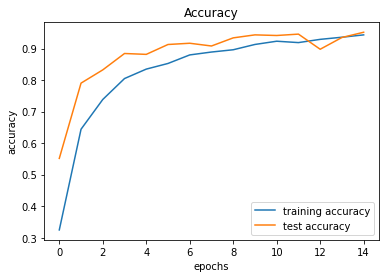

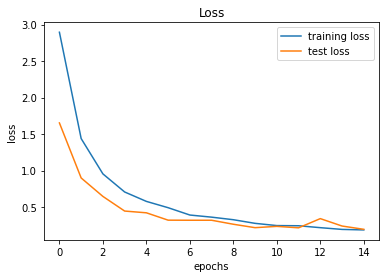

In [36]:
'''
On plot les résultats de performances
'''

plt.figure(0)
plt.plot(anc.history['accuracy'], label='training accuracy')
plt.plot(anc.history['val_accuracy'], label='test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(anc.history['loss'], label='training loss')
plt.plot(anc.history['val_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

A partir d'un ensemble de feature X_predict :

pred = model.predict_classes(X_predict)
print(accuracy_score(y_predict, pred))